<a href="https://colab.research.google.com/github/EdithOroche/IA/blob/main/Segmentaci%C3%B3n_Binaria_L10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0. Descargar el conjunto de datos

In [1]:
import kagglehub
ivarvb_ds2024iidccecv2_path = kagglehub.dataset_download('ivarvb/ds2024iidccecv2')

100%|██████████| 404M/404M [00:02<00:00, 158MB/s]

Extracting files...


In [2]:
import kagglehub
ivarvb_ds2024iidccecv2_path = kagglehub.dataset_download('ivarvb/ds2024iidccecv2')

Using Colab cache for faster access to the 'ds2024iidccecv2' dataset.


#1. Segmentación binaria de imágenes

La segmentación binaria de imágenes es una técnica del procesamiento digital que consiste en separar los píxeles de una imagen en dos clases: **primer plano** (objeto de interés) y **fondo**. Para lograr esto se genera una máscara binaria donde los píxeles pertenecientes al objeto tienen un valor de 1 (blanco) y los del fondo tienen un valor de 0 (negro).

#2. Importando bibliotecas

In [ ]:
import os

from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.layers import SpatialDropout2D,Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate,AveragePooling2D, UpSampling2D, BatchNormalization, Activation, add,Dropout,Permute,ZeroPadding2D,Add, Reshape

from tensorflow.keras.layers import AveragePooling2D, GlobalAveragePooling2D, UpSampling2D, Reshape, Dense
from tensorflow.keras.models import Model
import tensorflow as tf

import cv2
from glob import glob
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy, Recall, Precision

from typing import Any

import tensorflow as tf
from tensorflow.keras import backend as K

from tensorflow.keras.layers import Flatten

from tensorflow.python.keras.backend import set_session

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

#3. Asegurando Reproductibilidad

In [4]:
def setseed():
    os.environ['PYTHONHASHSEED'] = '0'
    #os.environ['CUDA_VISIBLE_DEVICES'] = ''
    SEED = 1030
    np.random.seed(SEED)
    random.seed(SEED)

    #*********************************************************************************#
    # fix seed for reproducible results (only works on CPU, not GPU)
    seed_value = SEED #default
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    #tf.set_random_seed(seed_value)
    #config = tf.ConfigProto()
    config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    config.gpu_options.allow_growth = True
    set_session(tf.compat.v1.Session(graph = tf.compat.v1.get_default_graph(), config = config))

setseed()

print("tf.version",tf.__version__)

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

inputdir = "/kaggle/input/ds2024iidccecv2/melanoma/"
outputdir = "/kaggle"

pathtrain = os.path.join(inputdir,"train")
pathtest = os.path.join(inputdir,"test")
pathtrainaug = os.path.join(inputdir, "train_augmented")

csv_path = os.path.join(outputdir, "Epoch_Log.csv")

model_weights_path = os.path.join(outputdir, "model_weights.weights.h5")
model_path = os.path.join(outputdir, "model.keras")


# LR = 2e-4
LR = 2e-5

H = 512
W = 512

batches=1
#epochs=80
epochs=30

stop_early=False
SMOOTH = 1e-15

# LR = 1e-5
# LR = 4e-4

# MEAN = [0.485, 0.456, 0.406]
# STD = [0.229, 0.224, 0.225]

tf.version 2.19.0


#4. Implementado el modelo

El modelo utilizado para la segmentación es **U-Net**, una arquitectura ampliamente usada en segmentación de imágenes biomédicas. U-Net se caracteriza por su estructura en forma de "U", que combina un **encoder** (contracción) y un **decoder** (expansión).

### Encoder (contracción)
Reduce progresivamente el tamaño de la imagen mediante convoluciones y max-pooling, permitiendo extraer características profundas del objeto. Esta etapa captura qué hay en la imagen.

### Decoder (expansión)
Aumenta de nuevo la resolución usando capas *Conv2DTranspose*, recuperando la forma original de la imagen segmentada. Esta etapa recupera dónde está el objeto.

### Skip Connections
Una de las claves de U-Net son las **conexiones de salto**, que concatenan características del encoder directamente al decoder. Esto ayuda a recuperar información espacial fina que se perdería en el proceso de reducción.

### Ventajas de U-Net
- Excelente desempeño con pocos datos.
- Buena preservación de detalles.
- Capaz de segmentar estructuras pequeñas.

In [5]:
"""
ref from: https://towardsdatascience.com/image-segmentation-unet-and-deep-supervision-loss-using-keras-model-f21a9856750a
"""
def conv_block(inp, filters, padding='same', activation='relu'):
    x = Conv2D(filters, (3, 3), padding=padding, activation=activation)(inp)
    x = Conv2D(filters, (3, 3), padding=padding)(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation(activation)(x)
    return x


def encoder_block(inp, filters, padding='same', pool_stride=2, activation='relu'):
    x = conv_block(inp, filters, padding, activation)
    p = MaxPooling2D(pool_size=(2, 2), strides=pool_stride)(x)
    return x, p

def decoder_block(inp,filters,concat_layer,padding='same'):
    #Upsample the feature maps
    x=Conv2DTranspose(filters,(2,2),strides=(2,2),padding=padding)(inp)
    x=concatenate([x,concat_layer])#Concatenation/Skip conncetion with conjuagte encoder
    x=conv_block(x,filters)#Passed into the convolution block above
    return x

def build_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    d1,p1=encoder_block(inputs,64)
    d2,p2=encoder_block(p1,128)
    d3,p3=encoder_block(p2,256)
    d4,p4=encoder_block(p3,512)

    mid=conv_block(p4,1024) #Midsection

    e2=decoder_block(mid,512,d4) #Conjugate of encoder 4
    e3=decoder_block(e2,256,d3) #Conjugate of encoder 3
    e4=decoder_block(e3,128,d2) #Conjugate of encoder 2
    e5=decoder_block(e4,64,d1) #Conjugate of encoder 1
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(e5) #Final Output
    model=Model(inputs, outputs, name='Unet')
#     model=Model(inputs=[inputs],outputs=[outputs,o1],name='Unet')
#     model = Model(inputs, outputs, name="ResNet50_U-Net")
    return model



#5. Métricas

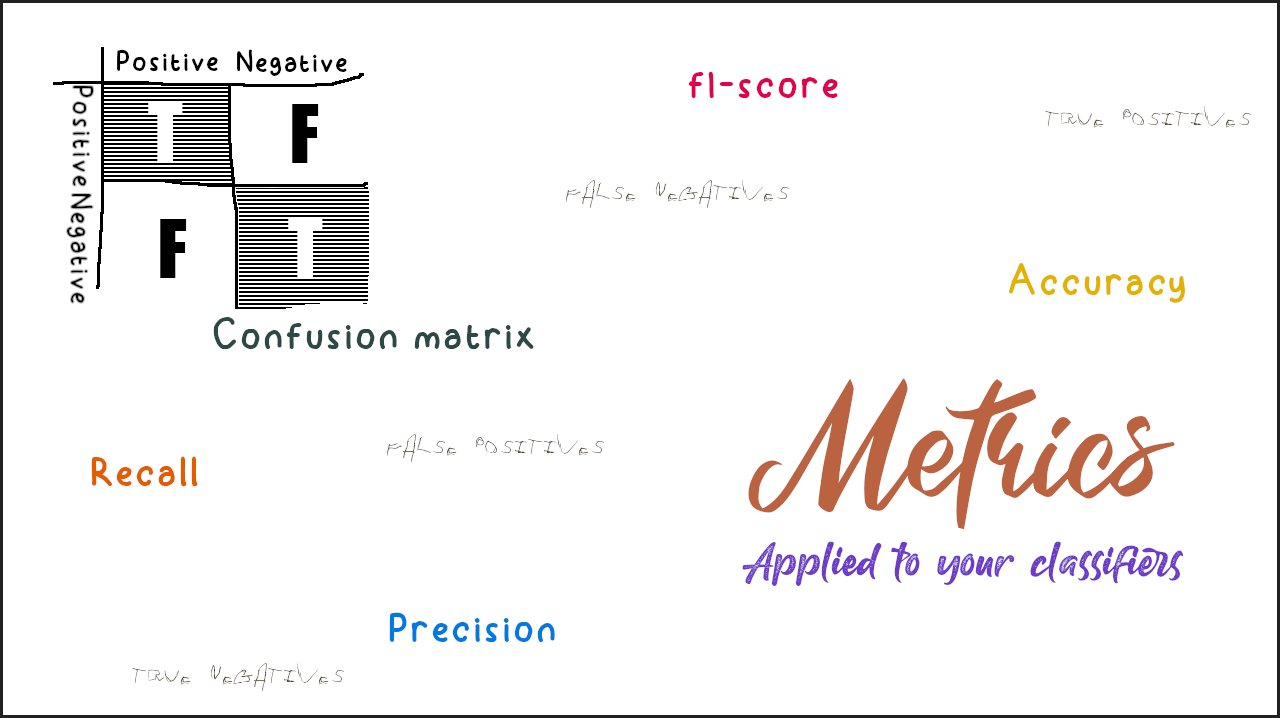

**1. IoU (Intersection over Union)**

El IoU es una métrica usada principalmente en segmentación de imágenes y detección de objetos. Evalúa qué tanto coincide la predicción con la verdad real midiendo el grado de superposición entre ambas. Calcula la relación entre el área de intersección y el área de unión de las dos máscaras.

*   Un valor de 1 indica coincidencia perfecta.
*   Un valor cercano a 0 indica muy poca superposición.

*Formula*
$$
IoU = \frac{TP}{TP + FP + FN}
$$

**2. Coeficiente Dice (Dice Score)**

El Coeficiente Dice mide la similitud entre dos conjuntos, especialmente útil en segmentación semántica, donde se busca evaluar qué tan bien se solapan las regiones predichas y reales. Da mayor peso a los verdaderos positivos y es muy sensible a objetos pequeños. Un valor alto indica mayor solapamiento entre predicción y ground truth.

Está estrechamente relacionado con el F1-score.

*Formula*

$$
Dice = \frac{2 \cdot TP}{2 \cdot TP + FP + FN}
$$

**3. Accuracy (Exactitud)**

La accuracy representa el porcentaje de predicciones correctas respecto al total de muestras evaluadas. Considera tanto los aciertos en la clase positiva como en la negativa. El cual es útil cuando las clases están equilibradas.

Puede ser engañosa en conjuntos de datos desbalanceados porque un modelo puede obtener alta exactitud solo prediciendo la clase mayoritaria.

*Formula*

$$
Accuracy = \frac{TP + TN}{TP + TN + FP + FN}
$$

**4. Precision (Precisión)**

La precision indica qué proporción de las predicciones clasificadas como positivas son realmente correctas.

Alta precisión significa que el modelo comete pocos falsos positivos.

Es una medida importante cuando es costoso clasificar algo como positivo por error (por ejemplo, detectar cáncer cuando no lo hay).

*Formula*

$$
Precision = \frac{TP}{TP + FP}
$$


**5. Recall (Sensibilidad o Exhaustividad)**

El recall mide la capacidad del modelo para detectar correctamente todos los elementos positivos reales.

Un recall alto significa que el modelo comete pocos falsos negativos.

Es importante en escenarios donde no detectar un positivo tiene un alto costo (por ejemplo, detección de intrusiones o fraude).

*Formula*

$$
Recall = \frac{TP}{TP + FN}
$$

**6. F1-score**

El F1-score es la media armónica entre precision y recall, lo que lo convierte en una métrica equilibrada cuando se necesita medir ambas al mismo tiempo.

Es especialmente útil cuando las clases están desbalanceadas.

Favorece modelos que mantienen buena precisión y buen recall, evitando que uno sea muy alto a costa del otro.

*Formula*
$$
F1 = \frac{2TP}{2TP + FP + FN}
$$

In [6]:
def iou(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    x = (intersection + SMOOTH) / (union + SMOOTH)
    return x

def dice_coef(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + SMOOTH) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + SMOOTH)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)


# Evaluation Metrics
def eval_iou(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    y_true[y_true > 0] = 1  # normalize binary mask
    y_true = y_true.astype(np.float32)

    intersection = (y_true * y_pred).sum()
    union = y_true.sum() + y_pred.sum() - intersection

    x = (intersection + SMOOTH) / (union + SMOOTH)
    x = x.astype(np.float32)
    return x


def eval_dice_coef(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    y_true[y_true > 0] = 1  # normalize binary mask
    y_true = y_true.astype(np.float32)

    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred)

    if union == 0:
        return 1.0  # Handle the case where both masks are empty

    dice = (2.0 * intersection + SMOOTH) / (union + SMOOTH)
    return dice


def accuracy_score(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    y_true[y_true > 0] = 1  # normalize binary mask
    y_true = y_true.astype(np.float32)

    correct = np.sum(y_true == y_pred)
    total = y_true.size
    accuracy = correct / total

    return accuracy


def precision_score(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    y_true[y_true > 0] = 1  # normalize binary mask
    y_true = y_true.astype(np.float32)

    TP = np.sum((y_true == 1) & (y_pred == 1))
    FP = np.sum((y_true == 0) & (y_pred == 1))

    if TP + FP == 0:
        return 1.0  # case where both TP and FP are zero

    precision = TP / (TP + FP)

    return precision


def recall_score(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    y_true[y_true > 0] = 1  # normalize binary mask
    y_true = y_true.astype(np.float32)

    TP = np.sum((y_true == 1) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))

    if TP + FN == 0:
        return 1.0  # case where TP and FN are zero

    recall = TP / (TP + FN)
    return recall


def f1_score(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    y_true[y_true > 0] = 1  # normalize binary mask
    y_true = y_true.astype(np.float32)

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)

    if precision + recall == 0:
        return 0.0  # Handle the case where both precision and recall are zero

    f1 = 2 * (precision * recall) / (precision + recall)
    return f1

#6. Cargando los datos

In [7]:
# H = 256
# W = 256


# def shuffling(x: list[str], y: list[str]) -> list[str]:
#     x, y = shuffle(x, y, random_state=42)
#     return x, y

def loadDataAug(path: str) -> list[str]:
    x = sorted(glob(os.path.join(path, "images", "*jpg")))
    y = sorted(glob(os.path.join(path, "groundtruths", "*jpg")))
    return x, y


def loadData(path: str) -> list[str]:
    x = sorted(glob(os.path.join(path, "images", "*jpg")))
    y = sorted(glob(os.path.join(path, "groundtruths", "*jpg")))
    return x, y


def read_image_t(path: Any) -> Any:
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB).astype(np.float32)

#     x = cv2.imread(path, cv2.IMREAD_COLOR).astype(np.float32)
    x = cv2.resize(x, (H, W))

    x = x / 255.0  # normalizing and standardizing image with Imagenet specifications
#     x -= MEAN
#     x /= STD
    return x


def read_image(path: Any) -> Any:
    path = path.decode()
    return read_image_t(path)


def read_mask_t(path: Any) -> Any:
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
    x = cv2.resize(x, (H, W))

    x = x / 255.0  # normalizing mask
    x = np.expand_dims(x, axis=-1)
    return x

def read_mask(path: Any) -> Any:
    path = path.decode()
    return read_mask_t(path)


def tf_parse(x: Any, y: Any) -> Any:
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
#     print("x.shape, y.shape", x.shape, y.shape)
    return x, y


def tf_dataset(X: Any, Y: Any, batch: int = 2) -> Any:
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(4)
    return dataset


def readDatasetFiles(ptrain, ptest, val_size=0.1, ptrainaugment=None):
    x_test, y_test = loadData(ptest)
    x_train, y_train = loadData(ptrain)
    # print("XX",x_test, y_test, x_train, y_train)

#     if not ptrainaugment == None:
#         x_train_aug, y_train_aug = loadDataAug(ptrainaugment)
#         print(f"Train_aug:\n Images: {len(x_train)}\tMasks: {len(y_train)}\n")
#         x_train += x_train_aug
#         y_train += y_train_aug

    x_train, y_train = shuffle(x_train, y_train, random_state=42)
#     x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_size)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=len(x_test))

    print(f"Test:\n Images: {len(x_test)}\tMasks: {len(y_test)}\n")
    print(f"Train:\n Images: {len(x_train)}\tMasks: {len(y_train)}\n")
    print(f"Validation:\n Images: {len(x_val)}\tMasks: {len(y_val)}\n")

    return x_train, y_train, x_val, y_val, x_test, y_test

#7. Funciones de evaluación

In [8]:
################################
#### BEGING: EVALUATE ##########
################################
def vis(filename, image, mask, predicted):
    namef = os.path.splitext(os.path.basename(filename))[0]

    # results - plot
    fig, ax = plt.subplots(1,3, figsize=(10,15))
    ax[0].imshow(image, 'gray')
    ax[0].set_title('image')

    ax[1].imshow(mask, 'gray')
    ax[1].set_title('GT')

#     ax[2].imshow(predicted, cmap='jet')
    ax[2].imshow(predicted, cmap='gnuplot')
    ax[2].set_title('Predicted')

def savenp(filen, obj):
    with open(filen, 'wb') as f:
        np.save(f, obj)

def makedir(dirpath):
    if not os.path.isdir(dirpath):
        os.mkdir(dirpath)

def evaluateModel(model, testds, batches):
    test_x, test_y = testds

    model.load_weights(model_weights_path)
    model.save(model_path)
    data = {'dice': [], 'iou': []}
    for i in range(len(test_y)):
        namef = os.path.splitext(os.path.basename(test_x[i]))[0]
        image = read_image_t(test_x[i])

        y_r = read_mask_t(test_y[i]) #real
        y_p = model.predict(tf.expand_dims(image,axis=0))[0]#predicted

        savenp(os.path.join(outputdir, "results", namef+".npy"), y_p)

        y_p = (y_p > 0.5).astype(np.float32)

        print("y_p.shape, y_r.shape", y_p.shape, y_r.shape)

        data["dice"].append(round(dice_coef(y_r, y_p).numpy(), 4))
        data["iou"].append(round(iou(y_p, y_r).numpy(), 4))

        vis(test_x[i], image, y_r, y_p)

    pdf = pd.DataFrame.from_dict(data)
    pdf.to_csv(os.path.join(outputdir, "test_metrics.csv"))
    print("pdf", pdf)

    print('mean: ', pdf.mean(axis=0))
    print('std: ', pdf.std(axis=0))

################################
#### END: EVALUATE ##########
################################


#8. Entrenamiento del modelo

In [ ]:
if __name__ == "__main__":

    makedir(os.path.join(outputdir, "results"))

    # read files from path
    x_train, y_train, x_val, y_val, x_test, y_test = readDatasetFiles(pathtrain,
                                                                      pathtest,
                                                                      val_size=0.1,
                                                                      ptrainaugment=pathtrainaug
                                                                     )


    # read images from files to tf
    train_ds = tf_dataset(x_train, y_train, batch=batches)
    val_ds = tf_dataset(x_val, y_val, batch=batches)
    #test_ds = tf_dataset(x_test, y_test, batch=batches)

    model = build_unet((H, W, 3))


    # compile model
    model.compile(
        loss=dice_loss,
        optimizer=Adam(LR),
#         optimizer='adam',
        metrics=[dice_coef, iou],
    )

    callbacks = [
        ModelCheckpoint(model_weights_path, verbose=1, save_best_only=True, save_weights_only=True),
        ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        CSVLogger(csv_path),
        TensorBoard(log_dir="logs"),

    ]

    if stop_early:
        callbacks.append(
            EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=False),
        )

    # training mondel
    model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        batch_size=batches,
        callbacks=callbacks
    )

    # test evaluation
    evaluateModel(model, (x_test, y_test), batches)

Test:
 Images: 98	Masks: 98

Train:
 Images: 802	Masks: 802

Validation:
 Images: 98	Masks: 98

Epoch 1/30
802/802 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - dice_coef: 0.6076 - iou: 0.4780 - loss: 0.3924
Epoch 1: val_loss improved from inf to 0.30702, saving model to /kaggle/model_weights.weights.h5
802/802 ━━━━━━━━━━━━━━━━━━━━ 255s 270ms/step - dice_coef: 0.6077 - iou: 0.4781 - loss: 0.3923 - val_dice_coef: 0.6930 - val_iou: 0.5739 - val_loss: 0.3070 - learning_rate: 2.0000e-05
Epoch 2/30
802/802 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - dice_coef: 0.7685 - iou: 0.6505 - loss: 0.2315
Epoch 2: val_loss improved from 0.30702 to 0.29419, saving model to /kaggle/model_weights.weights.h5
802/802 ━━━━━━━━━━━━━━━━━━━━ 217s 270ms/step - dice_coef: 0.7685 - iou: 0.6506 - loss: 0.2315 - val_dice_coef: 0.7058 - val_iou: 0.5901 - val_loss: 0.2942 - learning_rate: 2.0000e-05
Epoch 3/30
802/802 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - dice_coef: 0.8109 - iou: 0.7014 - loss: 0.1891
Epoch 3: val_loss improved from